In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [3]:
df = df.rename(columns={'conversion': 'target', 'offer': 'treatment'})

In [4]:
# Приведение столбца 'treatment' к бинарному виду

df.loc[df["treatment"] == "No Offer", "treatment"] = 0
df.loc[df["treatment"] != 0, "treatment"] = 1

In [5]:
cat_features = ["zip_code", "channel"]

In [6]:
encoded_columns = pd.get_dummies(df[cat_features])

df = df.join(encoded_columns).drop(cat_features, axis=1)

columns = list(df.columns.values) 
columns

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'is_referral',
 'treatment',
 'target',
 'zip_code_Rural',
 'zip_code_Surburban',
 'zip_code_Urban',
 'channel_Multichannel',
 'channel_Phone',
 'channel_Web']

In [7]:
df = df[['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'zip_code_Rural', 'zip_code_Surburban',
        'zip_code_Urban', 'channel_Multichannel', 'channel_Phone', 'channel_Web', 'treatment', 'target']]

In [8]:
df['treatment'] = df['treatment'].astype('int')

In [9]:
df_train, df_test = train_test_split(df, shuffle=True, test_size=0.30, random_state=17)

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=123)

df_features = df

X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment']

X_test = df_features.loc[indices_test, :]

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [10]:
!pip install scikit-uplift

In [11]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

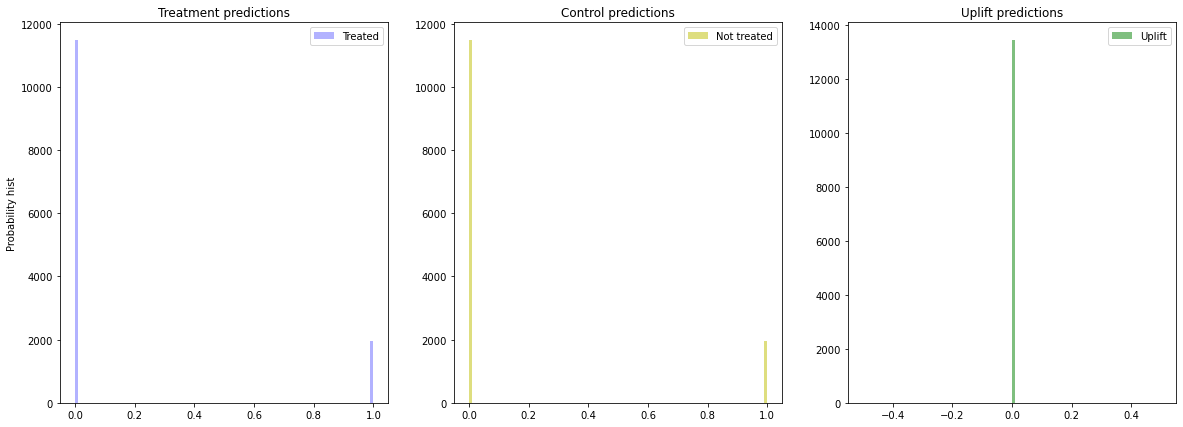

In [12]:
sm = SoloModel(LGBMClassifier(random_state=15))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

sm_trmnt_preds = sm.trmnt_preds_

sm_ctrl_preds = sm.ctrl_preds_

plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [13]:
from sklift.models import ClassTransformation


ct = ClassTransformation(LGBMClassifier(random_state=15))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

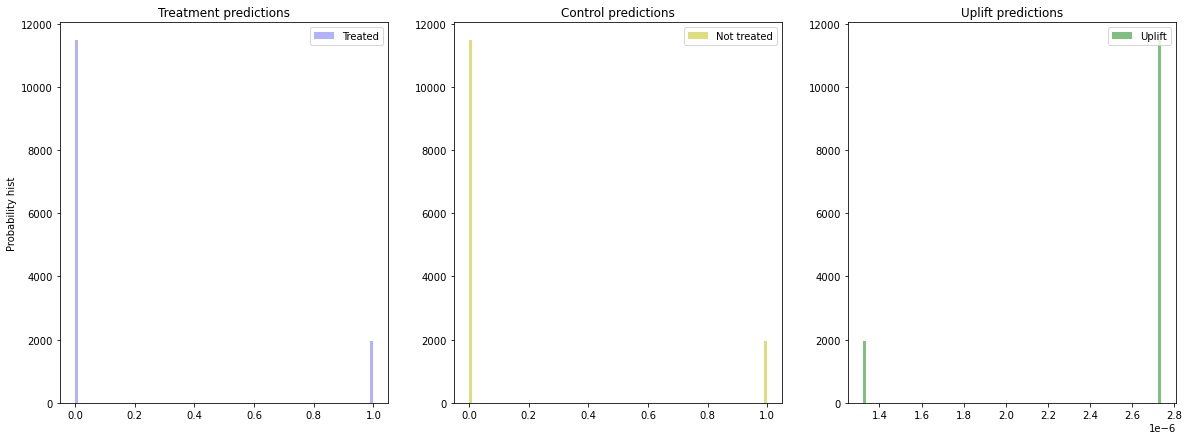

In [14]:
from sklift.models import TwoModels

tm = TwoModels(
    estimator_trmnt=LGBMClassifier(random_state=15), 
    estimator_ctrl=LGBMClassifier(random_state=15), 
    method='vanilla')

tm = tm.fit(X_train, y_train, treat_train)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [15]:
results = pd.DataFrame(data=models_results)

results

,approach,uplift@10%,uplift@20%
0,SoloModel,0.066994,0.060354
1,ClassTransformation,1.000000,0.842223
2,TwoModels,0.000000,0.000000


In [40]:
features = [col for col in X_train]

In [30]:
%cd causalml
!pip install -r requirements.txt
!python setup.py build_ext --inplace
!python setup.py install

C:\Users\kto-k\Downloads\Telegram Desktop\business\les_4\causalml
  Using cached scipy-1.4.1-cp38-cp38-win_amd64.whl (31.0 MB)
  Using cached slicer-0.0.3-py3-none-any.whl (11 kB)
  Using cached progressbar2-3.53.1-py2.py3-none-any.whl (25 kB)
  Using cached absl_py-0.12.0-py3-none-any.whl (129 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached grpcio-1.34.1-cp38-cp38-win_amd64.whl (2.9 MB)
  Using cached h5py-3.1.0-cp38-cp38-win_amd64.whl (2.7 MB)
  Using cached keras_nightly-2.5.0.dev2021032900-py2.py3-none-any.whl (1.2 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached protobuf-3.17.0-py2.py3-none-any.whl (173 kB)
  Using cached tensorboard-2.5.0-py3-none-any.whl (6.0 MB)
  Using cached tensorflow_estimator-2.5.0rc0-py2.py3-none-any.whl (462 kB)
Pr

ERROR: tensorflow 2.5.0rc3 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: tensorflow 2.5.0rc3 has requirement wheel~=0.35, but you'll have wheel 0.34.2 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Отказано в доступе: 'c:\\programdata\\anaconda3\\lib\\site-packages\\scipy-1.5.0.dist-info\\direct_url.json'
Consider using the `--user` option or check the permissions.



Compiling causalml/inference/tree/causaltree.pyx because it changed.
[1/1] Cythonizing causalml/inference/tree/causaltree.pyx
running build_ext
building 'causalml.inference.tree.causaltree' extension
creating build
creating build\temp.win-amd64-3.8
creating build\temp.win-amd64-3.8\Release
creating build\temp.win-amd64-3.8\Release\causalml
creating build\temp.win-amd64-3.8\Release\causalml\inference
creating build\temp.win-amd64-3.8\Release\causalml\inference\tree
C:\Program Files (x86)\Microsoft Visual Studio\2019\BuildTools\VC\Tools\MSVC\14.27.29110\bin\HostX86\x64\cl.exe /c /nologo /Ox /W3 /GL /DNDEBUG /MD -IC:\ProgramData\Anaconda3\lib\site-packages\numpy\core\include -IC:\ProgramData\Anaconda3\lib\site-packages\numpy\core\include -IC:\ProgramData\Anaconda3\include -IC:\ProgramData\Anaconda3\include "-IC:\Program Files (x86)\Microsoft Visual Studio\2019\BuildTools\VC\Tools\MSVC\14.27.29110\include" "-IC:\Program Files (x86)\Windows Kits\NETFXSDK\4.8\include\um" "-IC:\Program Files 

cl: Є®¬ ­¤­ п бва®Є  warning D9002: Їа®ЇгбЄ ­ҐЁ§ўҐбв­®Ј® Ї а ¬Ґва  "-O3"
C:\ProgramData\Anaconda3\lib\site-packages\Cython\Compiler\Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\kto-k\Downloads\Telegram Desktop\business\les_4\causalml\causalml\inference\tree\causaltree.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)



‘®§¤ ­ЁҐ Є®¤  § ўҐаиҐ­®
copying build\lib.win-amd64-3.8\causalml\inference\tree\causaltree.cp38-win_amd64.pyd -> causalml\inference\tree
running install
running bdist_egg
running egg_info
creating causalml.egg-info
writing causalml.egg-info\PKG-INFO
writing dependency_links to causalml.egg-info\dependency_links.txt
writing requirements to causalml.egg-info\requires.txt
writing top-level names to causalml.egg-info\top_level.txt
writing manifest file 'causalml.egg-info\SOURCES.txt'
reading manifest file 'causalml.egg-info\SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'causalml.egg-info\SOURCES.txt'
installing library code to build\bdist.win-amd64\egg
running install_lib
running build_py
copying causalml\features.py -> build\lib.win-amd64-3.8\causalml
copying causalml\match.py -> build\lib.win-amd64-3.8\causalml
copying causalml\propensity.py -> build\lib.win-amd64-3.8\causalml
copying causalml\__init__.py -> build\lib.win-amd64-3.8\causalml
creating build\li

zip_safe flag not set; analyzing archive contents...
causalml.inference.tree.__pycache__.causaltree.cpython-38: module references __file__
error removing c:\programdata\anaconda3\lib\site-packages\causalml-0.10.0-py3.8-win-amd64.egg: [WinError 5] Отказано в доступе: 'c:\\programdata\\anaconda3\\lib\\site-packages\\causalml-0.10.0-py3.8-win-amd64.egg\\causalml\\inference\\tree\\causaltree.cp38-win_amd64.pyd'
error removing c:\programdata\anaconda3\lib\site-packages\causalml-0.10.0-py3.8-win-amd64.egg: [WinError 145] Папка не пуста: 'c:\\programdata\\anaconda3\\lib\\site-packages\\causalml-0.10.0-py3.8-win-amd64.egg\\causalml\\inference\\tree'
error removing c:\programdata\anaconda3\lib\site-packages\causalml-0.10.0-py3.8-win-amd64.egg: [WinError 145] Папка не пуста: 'c:\\programdata\\anaconda3\\lib\\site-packages\\causalml-0.10.0-py3.8-win-amd64.egg\\causalml\\inference'
error removing c:\programdata\anaconda3\lib\site-packages\causalml-0.10.0-py3.8-win-amd64.egg: [WinError 145] Папка н

In [45]:
from causalml.inference.tree.models import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree.plot import uplift_tree_string, uplift_tree_plot

ModuleNotFoundError: No module named 'causalml.inference.tree.plot'

In [44]:
%%time
from IPython.display import Image
from causalml.inference.tree.models import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree.plot import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

ModuleNotFoundError: No module named 'causalml.inference.tree.plot'